In [3]:
from fits_reader import *
import pylab as plt
def pad_batch(batch, l=16, p=1):
    pad = np.mean(batch[:,l-1:l+1, :, :], axis=1, keepdims=True)
    print(pad.shape)
    padded = np.concatenate([batch[:,:l, :, :], pad, pad, batch[:,l:, :, :]], axis=1)
    return padded

In [4]:
files = find_files('../Data/', pattern='*OFF.fits', pair=True)
#files = find_pairs('../Convolutional-LSTM-in-Tensorflow/train_data')
batch = load_batch(10200, files, 0, with_y=True, normalize='max')
batch = pad_batch(batch)

(10200, 1, 512, 1)


(10200, 34, 512, 1)


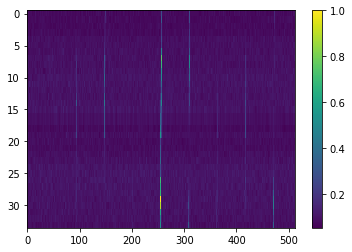

In [5]:
print(batch.shape)
plt.imshow(batch[19].squeeze(), aspect='auto')
plt.colorbar()
plt.show()

In [8]:
batch.shape
def make_movie(frame, l=16, step=5):
    L = frame.shape[0]
    movie = np.stack([frame[i:i+l] for i in range(0, L-l, step)], axis=0)
    return movie
movie_batch = np.stack([make_movie(frame) for frame in batch], axis=0)
print(movie_batch.shape)

(10200, 4, 16, 512, 1)


In [15]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt
from keras.utils import multi_gpu_model

# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=8, kernel_size=(1, 3),
                   input_shape=(None, 16, 512, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=8, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=8, kernel_size=(1, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=8, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(1, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
#seq = multi_gpu_model(seq, gpus=2)
seq.compile(loss='binary_crossentropy', optimizer='adadelta')
seq.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_17 (ConvLSTM2D) (None, None, 16, 512, 8)  896       
_________________________________________________________________
batch_normalization_17 (Batc (None, None, 16, 512, 8)  32        
_________________________________________________________________
conv_lst_m2d_18 (ConvLSTM2D) (None, None, 16, 512, 8)  4640      
_________________________________________________________________
batch_normalization_18 (Batc (None, None, 16, 512, 8)  32        
_________________________________________________________________
conv_lst_m2d_19 (ConvLSTM2D) (None, None, 16, 512, 8)  1568      
_________________________________________________________________
batch_normalization_19 (Batc (None, None, 16, 512, 8)  32        
_________________________________________________________________
conv_lst_m2d_20 (ConvLSTM2D) (None, None, 16, 512, 8)  4640      
__________

In [16]:
seq.fit(movie_batch[:10000, :-1], movie_batch[:10000, 1:], batch_size=32,
        epochs=5, validation_split=0.05)

Train on 9500 samples, validate on 500 samples
Epoch 1/5
9500/9500 [==============================] - 113s 12ms/step - loss: 0.3179 - val_loss: 0.2572
Epoch 2/5
9500/9500 [==============================] - 112s 12ms/step - loss: 0.2616 - val_loss: 0.2551
Epoch 3/5
9500/9500 [==============================] - 112s 12ms/step - loss: 0.2607 - val_loss: 0.2554
Epoch 4/5
9500/9500 [==============================] - 112s 12ms/step - loss: 0.2600 - val_loss: 0.2539
Epoch 5/5
9500/9500 [==============================] - 112s 12ms/step - loss: 0.2596 - val_loss: 0.2540


(2, 16, 512, 1)
(3, 16, 512, 1)
(4, 16, 512, 1)
(5, 16, 512, 1)
(5, 16, 512, 1) (4, 16, 512, 1)
(31, 512) (36, 512)


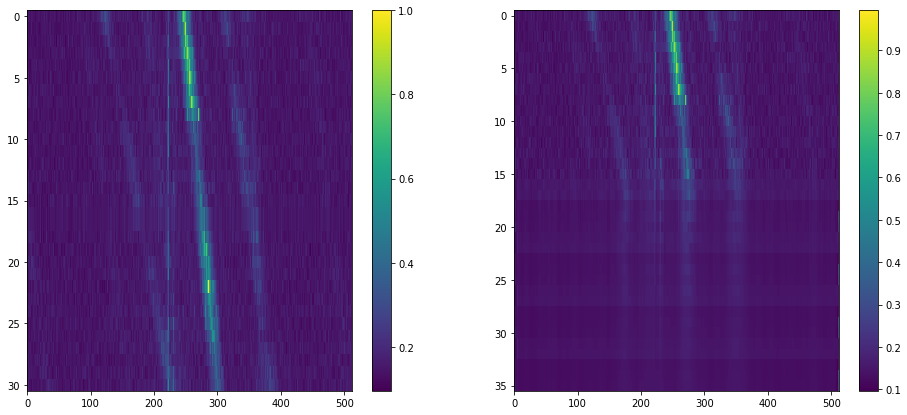

In [46]:
def make_frames(movie, l=4, step=1):
    #print(movie.shape)
    frame = [movie[0]]
    for m_frame in movie[1:]:
        frame.append(m_frame[-step:][...])
    #print([m.shape for m in frame])
    frame = np.concatenate(frame, axis=0).squeeze()
    return frame
Step = 5
which = 10150
track = movie_batch[which][:1, ::, ::, ::]
for j in range(4):
    new_pos = seq.predict(track[np.newaxis, -1:, ::, ::, ::])
    new = new_pos[0][::, ::, ::, ::]
    #print(new_pos.shape, track.shape, new.shape)
    track = np.concatenate((track, new), axis=0)
    print(track.shape)
    

track2 = movie_batch[which][::, ::, ::, ::]
print(track.shape, track2.shape)
GT = make_frames(track2, step=Step)
pred = make_frames(track, step=Step)
print(GT.shape, pred.shape)
plt.figure(figsize=(16,7))
plt.subplot(121)
plt.imshow(GT, aspect='auto')
plt.colorbar()
plt.subplot(122)
plt.imshow(pred, aspect='auto')
plt.colorbar()
plt.show()

In [35]:
!mv ../Convolutional-LSTM-in-Tensorflow/training_data/ ../Convolutional-LSTM-in-Tensorflow/Data/